## Sample Collection

In [200]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import pickle
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import LinearSVC

# Visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Map stuff
import folium
from folium.plugins import MarkerCluster

# Misc
from collections import Counter
sns.set()
%matplotlib inline

In [151]:
# GTD Dataset from 1970 - 2017
df = pd.read_csv("globalterrorismdb_0718dist.csv", encoding = "ISO-8859-1")

/Users/mel_ng/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [152]:
# GTD Dataset 1993
dftemp = pd.read_csv("gtd1993_0221dist.csv")
df = pd.concat([df,dftemp])

In [153]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
df = df.rename(columns={'iyear': "Year", 'imonth': "Month", 'iday': "Day"})
df = df[df['Day'] != 0]
df = df[df['Month'] != 0]
df['Timestamp'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df['Timestamp'] = df['Timestamp'].astype(str) + ' 00:00'
df['Timestamp'] = pd.to_datetime(df['Timestamp']).values.astype(int) / 10**9

## Data preparation


The columns we need are:

- Date
- Country data + location
- Time
- Attack type
- Target
- Number of people killed
- Number of people wounded
- Group name
- Number of perpertrators
- Motive
- Success rate
- Target victim information
- Perpetrator background
- Suicide
- Success
- Others...

For the columns with multiple categories, (e.g. attack type 1 and 2, target type 1 and 2) we will only be analysing the main type. (labelled 1)

There are some variables with multiple categorizations (different encoding schemes) but consisting the same data, such as 'country' and 'country_txt'. We have only chosen one of them to use. 

### Dealing with NULL values

In [154]:
df1 = df[[
    'Year',
    'Month',
    'Day',
    'Timestamp',
    'city',
    'country_txt',
    'region_txt',
    'attacktype1_txt',
    'target1',
    'nkill',
    'nwound',
    'gname',
    'nperps',
    'targtype1_txt',
    'targsubtype1_txt',
    'natlty1_txt',
    'weaptype1_txt',
    'motive',
    'suicide',
    'success',
    'nkillter',
    'nwoundte',
    'ishostkid',
    'extended',
    'crit1',
    'crit2',
    'crit3'
]]

In [155]:
df1['gname'].value_counts()[:5]

Unknown                                             82655
Taliban                                              7469
Islamic State of Iraq and the Levant (ISIL)          5613
Shining Path (SL)                                    4566
Farabundo Marti National Liberation Front (FMLN)     3343
Name: gname, dtype: int64

In [156]:
df1['weaptype1_txt'].value_counts()[:5]

Explosives    92460
Firearms      58560
Unknown       14948
Incendiary    11133
Melee          3649
Name: weaptype1_txt, dtype: int64

In [157]:
df1 = df[[
    'Year',
    'Month',
    'Day',
    'Timestamp',
    # 'city',
    'country_txt',
    'region_txt',
    'attacktype1_txt',
    # 'target1',
    'nkill',
    'nwound',
    # 'gname',
    # 'nperps',
    'targtype1_txt',
    'targsubtype1_txt',
    'natlty1_txt',
    'weaptype1_txt',
    # 'motive',
    'suicide',
    'success',
    # 'nkillter',
    # 'nwoundte',
    'ishostkid',
    'extended',
    'crit1',
    'crit2',
    'crit3'
]]

In [158]:
df1 = df1[df1['ishostkid'] != -9]

In [159]:
df1.shape

(181225, 20)

In [160]:
df1.dropna(axis=0, inplace=True)

In [161]:
df1 = df1[df1['weaptype1_txt'] != 'Unknown']

In [162]:
df_save = df1

## Feature Selection with Random Forest

In [163]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

In [164]:
X = df1.drop('success', axis=1)
y = df1['success']

### One-Hot encoding Categorical Data

From the following, we can see that there are many variables with the Dtype of 'object'. We must therefore one-hot encode these variables such that we are able to use them with the random forest.

Some are labelled as Dtype int but are categorical (Year, Month, Day) while others are already in one-hot encoded format (extended, ishostkid, crit1) - so we have to take note of this.

In [165]:
df1 = df1.rename(columns={"country_txt": "country", 
                    "region_txt": "region", 
                    "attacktype1_txt": "attacktype1", 
                    "targtype1_txt": "targtype1",
                    "weaptype1_txt": "weaptype1",
                    "natlty1_txt": "natlty1",
                    "targsubtype1_txt": "targsubtype1"})

In [166]:
categorical_cols = ['Year', 
                    'Month',
                    'Day', 
                    # 'city',
                    'country_txt',
                    'region_txt',
                    'attacktype1_txt',
                    # 'target1',
                    'targtype1_txt',
                    'targsubtype1_txt',
                    'natlty1_txt',
                    'weaptype1_txt',
                   ] 

X = pd.get_dummies(X, columns = categorical_cols)

In [167]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142362 entries, 5 to 448
Columns: 677 entries, Timestamp to weaptype1_txt_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)
dtypes: float64(4), int64(5), uint8(668)
memory usage: 101.6 MB


In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [169]:
forest = RandomForestClassifier(n_estimators=50)
sel = SelectFromModel(forest)
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=50))

In [170]:
list(X_train.columns[sel.get_support()])[:5]

['Timestamp', 'nkill', 'nwound', 'suicide', 'ishostkid']

In [171]:
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50)

In [172]:
importances = forest.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)
importances_sorted = forest_importances.sort_values(ascending=False)

In [173]:
sorted_features_set = []
for feature in importances_sorted.keys():
    if feature.split('_')[0] not in sorted_features_set:
        sorted_features_set.append(feature.split('_')[0])

The above shows the importance of the features in sorted order.

We will now use the top 12 variables (nkill all the way to targsubtype1) to predict the success rate using regression.

We will adjust the number a few times to see which is the best.

We might also want to consider removing "Day", "Month", and "Year" since they might not be very relevant to us

<font color='red'>*** When we did this sorting, we realised that because of the random split for train and test (we dont even use the test part) that the importance of individual features ranking might change, therefore in order to combat that, we will stick with using a few selected fields first.</font>

In [174]:
sorted_features_set[:12]

['Timestamp',
 'nkill',
 'attacktype1',
 'nwound',
 'weaptype1',
 'Month',
 'suicide',
 'targtype1',
 'Year',
 'Day',
 'crit3',
 'targsubtype1']

Although we used the text version of the features/variables earlier, we will make use of the non-text version here (applicable for weaptype1, attacktype1, targsubtype1, targtype1) as they hold basically the same data, but in another format.

In [175]:
df_small = df[sorted_features_set[:12] + ["success"]]

In [176]:
df_small.isnull().sum()

Timestamp           0
nkill           10165
attacktype1         0
nwound          16167
weaptype1           0
Month               0
suicide             0
targtype1           0
Year                0
Day                 0
crit3               0
targsubtype1    11051
success             1
dtype: int64

In [177]:
df_small.dropna(axis=0, inplace=True)

/Users/mel_ng/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [178]:
df_small = df_small[df_small["weaptype1"] != 13]
df_small = df_small[df_small["attacktype1"] != 9]
df_small = df_small[df_small["targtype1"] != 20]

In [179]:
df_small['success'].value_counts()

1.0    129226
0.0     13796
Name: success, dtype: int64

In [180]:
df_reduced = df_small[sorted_features_set[:1] + ['success']]

In [181]:
X = df_reduced.drop('success', axis=1)
y = df_reduced['success']

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## ML Model 1: RandomForestClassification

In [183]:
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50)

[[  121  2656]
 [  288 25540]]
              precision    recall  f1-score   support

         0.0       0.30      0.04      0.08      2777
         1.0       0.91      0.99      0.95     25828

    accuracy                           0.90     28605
   macro avg       0.60      0.52      0.51     28605
weighted avg       0.85      0.90      0.86     28605



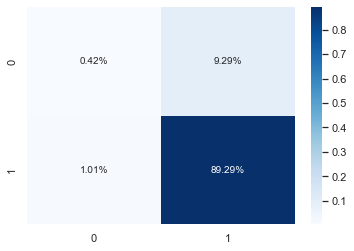

In [184]:
predictions = forest.predict(X_test)
c_matrix = metrics.confusion_matrix(y_test, predictions)
print(c_matrix)
# sns.heatmap(c_matrix, annot=True, cmap='Blues')
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, fmt='.2%', cmap='Blues')
print(classification_report(y_test, predictions))

In [185]:
filename = 'ml_model_1_RandomForestClassification.sav'
pickle.dump(forest, open(filename, 'wb'))

## ML Model 2: LogisticRegression

In [186]:
logreg = LogisticRegression(solver="sag", max_iter=400)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=400, solver='sag')

[[    0  2777]
 [    0 25828]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2777
         1.0       0.90      1.00      0.95     25828

    accuracy                           0.90     28605
   macro avg       0.45      0.50      0.47     28605
weighted avg       0.82      0.90      0.86     28605



/Users/mel_ng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mel_ng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mel_ng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


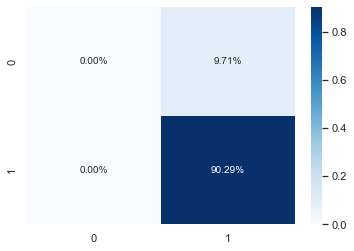

In [187]:
predictions = logreg.predict(X_test)
c_matrix = metrics.confusion_matrix(y_test, predictions)
print(c_matrix)
# sns.heatmap(c_matrix, annot=True, cmap='Blues')
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, fmt='.2%', cmap='Blues')
print(classification_report(y_test, predictions))

Looks like the recall is quite bad for values indicated as 0 (unsuccessful attacks). It's predicting many unsuccessful attacks as successful.

What about if we used less features? We will use 5 next.

In [188]:
filename = 'ml_model_2_LogReg.sav'
pickle.dump(logreg, open(filename, 'wb'))


<font color='blue'>Okay, not to be fooled by the score and accuracy (a stunning 0.91), when we first obtained the predictions we were a little scarred. Mainly because we kept scratching our heads at getting a model that was unable to predict 0. Delving deeper into the why, we realised that our dataset had a 10:1 ratio of success to failed outcome. Therefore the predictions probability for the 1 category was way higher than the 0 category as we can see that logreg.predict_proba(X_test) mostly gave us probabilities on the right hand side and collections.Counter(predictions) giving us all 1.</font>
<br><br>
<font color='blue'>
Hence from here, we conclude that LOG REG models go according to a graph and would output values that are most likely to happen (AKA 1) therefore we obtained all 1s. Therefore, log reg model is not a good model to use for this prediction, and we will continue to find out other ways to obtain the answer to our question.</font>

## ML Model 3: KNNClassification

#### Attempt 1: (2 neighbours)

In [189]:
nb = KNN(n_neighbors=2)
nb.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

[[  654  2123]
 [ 4479 21349]]
              precision    recall  f1-score   support

         0.0       0.13      0.24      0.17      2777
         1.0       0.91      0.83      0.87     25828

    accuracy                           0.77     28605
   macro avg       0.52      0.53      0.52     28605
weighted avg       0.83      0.77      0.80     28605



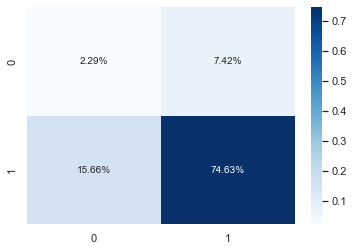

In [190]:
predictions = nb.predict(X_test)
c_matrix = metrics.confusion_matrix(y_test, predictions)
print(c_matrix)
# sns.heatmap(c_matrix, annot=True, cmap='Blues')
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, fmt='.2%', cmap='Blues')
print(classification_report(y_test, predictions))

Using a different model appears to have partially solved the issue of recall, and percentage of correctly predicted 0s is higher. However, the precision of both 0 and 1 values, as well as the recall of 1s has decreased. 

In [191]:
filename = 'ml_model_3_KNN_1.sav'
pickle.dump(nb, open(filename, 'wb'))

#### Attempt 2: (7 neighbours)

In [192]:
nb = KNN(n_neighbors=7)
nb.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

[[   81  2696]
 [  112 25716]]
              precision    recall  f1-score   support

         0.0       0.42      0.03      0.05      2777
         1.0       0.91      1.00      0.95     25828

    accuracy                           0.90     28605
   macro avg       0.66      0.51      0.50     28605
weighted avg       0.86      0.90      0.86     28605



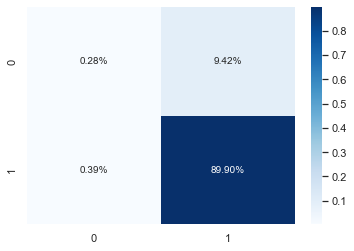

In [193]:
predictions = nb.predict(X_test)
c_matrix = metrics.confusion_matrix(y_test, predictions)
print(c_matrix)
# sns.heatmap(c_matrix, annot=True, cmap='Blues')
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, fmt='.2%', cmap='Blues')
print(classification_report(y_test, predictions))

In [194]:
filename = 'ml_model_3_KNN_2.sav'
pickle.dump(nb, open(filename, 'wb'))

## ML Model 4: LinearSVCModel
With a dash of balanced classweight. Doing a little penalization

#### Attempt 1: Non-weighted

In [201]:
lsvc = LinearSVC(verbose=0)
lsvc.fit(X_train, y_train)

/Users/mel_ng/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC()

[[   64  2713]
 [  347 25481]]
              precision    recall  f1-score   support

         0.0       0.16      0.02      0.04      2777
         1.0       0.90      0.99      0.94     25828

    accuracy                           0.89     28605
   macro avg       0.53      0.50      0.49     28605
weighted avg       0.83      0.89      0.86     28605



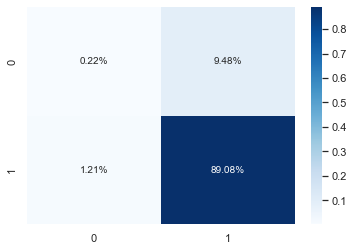

In [202]:
predictions = lsvc.predict(X_test)
c_matrix = metrics.confusion_matrix(y_test, predictions)
print(c_matrix)
# sns.heatmap(c_matrix, annot=True, cmap='Blues')
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, fmt='.2%', cmap='Blues')
print(classification_report(y_test, predictions))

In [203]:
filename = 'ml_model_4_LSVC_1.sav'
pickle.dump(lsvc, open(filename, 'wb'))

#### Attempt 2: Weighted

In [204]:
lsvc = LinearSVC(verbose=0, class_weight='balanced')
lsvc.fit(X_train, y_train)

/Users/mel_ng/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(class_weight='balanced')

[[   78  2699]
 [  455 25373]]
              precision    recall  f1-score   support

         0.0       0.15      0.03      0.05      2777
         1.0       0.90      0.98      0.94     25828

    accuracy                           0.89     28605
   macro avg       0.53      0.51      0.49     28605
weighted avg       0.83      0.89      0.85     28605



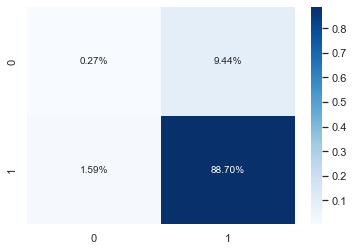

In [205]:
predictions = lsvc.predict(X_test)
c_matrix = metrics.confusion_matrix(y_test, predictions)
print(c_matrix)
# sns.heatmap(c_matrix, annot=True, cmap='Blues')
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, fmt='.2%', cmap='Blues')
print(classification_report(y_test, predictions))

## DL Model #3: Neural Networks

https://colab.research.google.com/drive/10HYEZTE6eBxMcmKeGYEd9iOkZpVuAlmH?usp=sharing

## Algorithmic Optimisation

### Boosting Algorithm #1: AdaBoost

### Boosting Algorithm #2: Gradient Boosting

### Model Validation Tool: K-Fold Cross-Validation

## Data cleaning with selected features

From our feature analysis with Random Forests, we have found the top 12 variables that contribute to the dataset.

In [ ]:
sorted_features_set[:12]

In [ ]:
df.shape

Although we used the text version of the features/variables earlier, we will make use of the non-text version here (applicable for weaptype1, attacktype1, targsubtype1, targtype1) as they hold basically the same data, but in another format.

In [ ]:
df_small = df[sorted_features_set[:12] + ["success"]]

In [ ]:
df_small.isnull().sum()

In [ ]:
df_small.dropna(axis=0, inplace=True)

In [ ]:
df_small.isnull().sum()

In [ ]:
df_small['weaptype1'].value_counts() # To remove 13

In [ ]:
df_small['attacktype1'].value_counts() # To remove 9

In [ ]:
df_small['targtype1'].value_counts() #To remove 20 (no 20s)

In [ ]:
df_small = df_small[df_small["weaptype1"] != 13]
df_small = df_small[df_small["attacktype1"] != 9]
df_small = df_small[df_small["targtype1"] != 20]

In [ ]:
df_small.shape

Tbh the number of points is not changed much - earlier its 142362 compared to now 143022. Doesn't really make much of a difference.

In [ ]:
df_small['success'].value_counts()

### Weighted logistic regression with increasing number of features

In [ ]:
weights = {0: 89, 1: 11}

In [ ]:
wlogreg = LogisticRegression(class_weight='balanced', solver="lbfgs", max_iter=1000)

In [ ]:
df_reduced = df_small[sorted_features_set[:1] + ['success']]

In [ ]:
X = df_reduced.drop('success', axis=1)
y = df_reduced['success']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
wlogreg.fit(X_train, y_train)

In [ ]:
predictions = wlogreg.predict(X_test)

In [ ]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)

In [ ]:
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
print(classification_report(y_test, predictions))

In [ ]:
# With 2

In [ ]:
weights = {0: 89, 1: 11}

In [ ]:
wlogreg = LogisticRegression(class_weight='balanced', solver="lbfgs", max_iter=1000)

In [ ]:
df_reduced = df_small[sorted_features_set[:2] + ['success']]

In [ ]:
X = df_reduced.drop('success', axis=1)
y = df_reduced['success']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
wlogreg.fit(X_train, y_train)

In [ ]:
predictions = wlogreg.predict(X_test)

In [ ]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)

In [ ]:
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
print(classification_report(y_test, predictions))

In [ ]:
# With 3

In [ ]:
weights = {0: 85, 1: 15}

In [ ]:
wlogreg = LogisticRegression(class_weight='balanced', solver="lbfgs", max_iter=1000)

In [ ]:
df_reduced = df_small[sorted_features_set[:3] + ['success']]

In [ ]:
reduced_columns = [
    # 'Month',
    # 'weaptype1',
    # 'Year',
    # 'targtype1',
    # 'Day',
    # 'targsubtype1',
    'attacktype1',
    # 'region',
    # 'natlty1',
    # 'country'
]

In [ ]:
df_reduced = pd.get_dummies(df_reduced, columns=reduced_columns)

In [ ]:
X = df_reduced.drop('success', axis=1)
y = df_reduced['success']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
wlogreg.fit(X_train, y_train)

In [ ]:
predictions = wlogreg.predict(X_test)

In [ ]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)

In [ ]:
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
print(classification_report(y_test, predictions))

In [ ]:
# With 4

In [ ]:
weights = {0: 85, 1: 15}

In [ ]:
wlogreg = LogisticRegression(class_weight='balanced', solver="lbfgs", max_iter=1000)

In [ ]:
df_reduced = df_small[sorted_features_set[:4] + ['success']]

In [ ]:
reduced_columns = [
    # 'Month',
    # 'weaptype1',
    # 'Year',
    # 'targtype1',
    # 'Day',
    # 'targsubtype1',
    'attacktype1',
    # 'region',
    # 'natlty1',
    # 'country'
]

In [ ]:
df_reduced = pd.get_dummies(df_reduced, columns=reduced_columns)

In [ ]:
X = df_reduced.drop('success', axis=1)
y = df_reduced['success']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
wlogreg.fit(X_train, y_train)

In [ ]:
predictions = wlogreg.predict(X_test)

In [ ]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)

In [ ]:
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
print(classification_report(y_test, predictions))

In [ ]:
weights = {0: 85, 1: 15}

In [ ]:
wlogreg = LogisticRegression(class_weight='balanced', solver="lbfgs", max_iter=1000)

In [ ]:
df_reduced = df_small[sorted_features_set[:5] + ['success']]

In [ ]:
reduced_columns = [
    # 'Month',
    'weaptype1',
    # 'Year',
    # 'targtype1',
    # 'Day',
    # 'targsubtype1',
    'attacktype1',
    # 'region',
    # 'natlty1',
    # 'country'
]

In [ ]:
df_reduced = pd.get_dummies(df_reduced, columns=reduced_columns)

In [ ]:
X = df_reduced.drop('success', axis=1)
y = df_reduced['success']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
wlogreg.fit(X_train, y_train)

In [ ]:
predictions = wlogreg.predict(X_test)

In [ ]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)

In [ ]:
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
print(classification_report(y_test, predictions))

In [ ]:
# What if we just use categorical data?

In [ ]:
reduced_columns = [
    'Month',
    'weaptype1',
    'Year',
    'targtype1',
    'Day',
    'targsubtype1',
    'attacktype1',
]

In [ ]:
weights = {0: 80, 1: 20}

In [ ]:
wlogreg = LogisticRegression(class_weight='balanced', solver="lbfgs", max_iter=1000)

In [ ]:
df_reduced = df_small[reduced_columns + ['success']]

In [ ]:
df_reduced = pd.get_dummies(df_reduced, columns=reduced_columns)

In [ ]:
X = df_reduced.drop('success', axis=1)
y = df_reduced['success']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
wlogreg.fit(X_train, y_train)

In [ ]:
predictions = wlogreg.predict(X_test)

In [ ]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)

In [ ]:
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
print(classification_report(y_test, predictions))